In [1]:
import bayesopt
#import gpbayesopt as bayesopt

import matplotlib.pyplot as plt
import seaborn as sns

from jax.config import config; config.update("jax_enable_x64", True)
from functools import partial
import jax.numpy as np

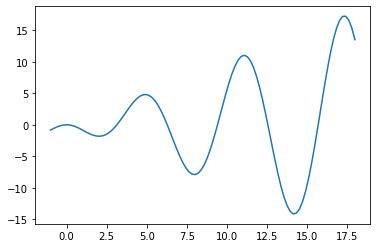

In [2]:
def f(x):
    return -x*np.sin(x)

plt.plot(np.linspace(-1,18,100),f(np.linspace(-1,18,100)))

# BO

In [3]:
# %%timeit
BO = bayesopt.BayesOpt(f=f,
                       initial_input=np.array([0.]),
                       acq=bayesopt.acquisition.LCB,
                       acq_optim=bayesopt.acquisition_optimizer.Acquisition_SLSQP_Optimizer(bounds=[0,18]),
                       maximize=False,
                       )
BO.run_optim(20)

BayesOpt: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s, param:[8.01553008], value:-7.911163104901827, current best param:[14.20729756], current best_value:-14.172373975184394]


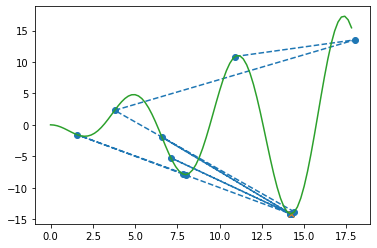

In [4]:
X = np.arange(0,18,0.2)
plt.plot(BO.param_history,BO.value_history,'o--')
plt.plot(BO.best_params,BO.best_value,'x')
plt.plot(X,f(X))

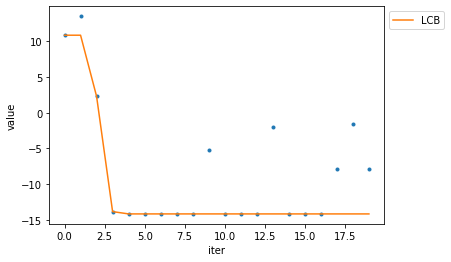

In [5]:
bayesopt.plot_history(BO)

In [2]:
def f(x,y):
    return (x-2.)**2 + (y+3)**2

def f2(x):
    return f(x[:,0],x[:,1])

In [3]:
# %%timeit
BO = bayesopt.BayesOpt(f=f2,
                       initial_input=np.array([[0.,0.]]),
                       acq=bayesopt.acquisition.LCB,
                       acq_optim=bayesopt.acquisition_optimizer.Acquisition_SLSQP_Optimizer(bounds=[[-5,5],[-5,5]]),
                       maximize=False,
                       function_input_unpacking=False,
                       )
BO.run_optim(20)

BayesOpt: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s, param:[ 1.02586352 -3.34440788], value:[1.06755867], current best param:[ 2.37174805 -2.85125311], current best_value:[0.16032225]]


# use original kernel and acq function

In [6]:
dists = bayesopt.utils.pairwise(bayesopt.metric.euclid_distance,square=True)
def kernel(x,y):
    return np.exp(-dists(x,y))
print(kernel(np.array([[2,3],[1,2]]),np.array([[2,3],[1,2],[1,1]])))

[[1.         0.13533528 0.00673795]
 [0.13533528 1.         0.36787944]]


In [7]:
def acq(mu,sigma,*args,**kwargs):
    '''
    mu, sigma, it=it, vmax=vmax, vmin=vminが入力されるようacq optimで決めている.
    '''
    it = kwargs.get('it',5.)
    return -mu+sigma*5*np.sqrt(np.log(it+1)/(it+1))

In [8]:
BO = bayesopt.BayesOpt(f=f,
                       initial_input=np.array([0.]),
                       kernel=kernel,
                       acq=acq,
                       acq_optim=bayesopt.acquisition_optimizer.Acquisition_L_BFGS_B_Optimizer(bounds=[0,18]))
BO.run_optim(20)

BayesOpt: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s, param:[13.85942469], value:-13.328288973036255, current best param:[14.20756296], current best_value:-14.172373999734996]


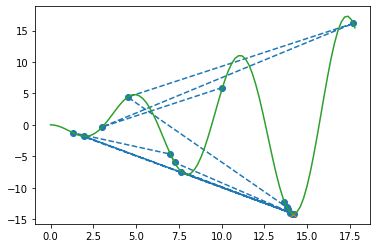

In [9]:
X = np.arange(0,18,0.2)
plt.plot(BO.param_history,BO.value_history,'o--')
plt.plot(BO.best_params,BO.best_value,'x')
plt.plot(X,f(X))

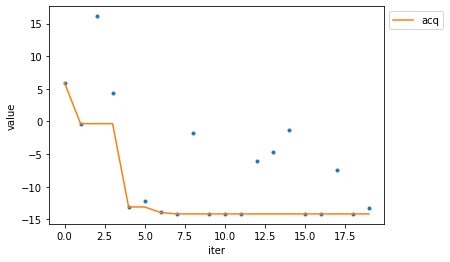

In [10]:
bayesopt.plot_history(BO)

# memo acuisition optimizer

In [11]:
def AcquisitionSLSQPOptimizer(gpr, acq, it, bounds, n_trial=5):
    ## gprとacqとitは受け取れるようにしないといけない. 
    ##boundsはfunctoolのpartialで指定するか、内部変数に持たせるか
    bounds = np.atleast_2d(bounds)
    vmax = np.max(gpr.Y_train)
    vmin = np.min(gpr.Y_train)
    ndim = len(bounds)
    loc = None
    value = None

    import scipy.optimize  
    def Obj(x):
        mu,sigma = gpr.posterior_predictive(np.atleast_2d(x),return_std=True)
        return -1.*acq(mu,sigma, it=it, vmax=vmax, vmin=vmin).ravel()

    x_seeds = onp.random.uniform(bounds[:,0],bounds[:,1], size=(n_trial,ndim)) 
    for xtry in x_seeds:
        res = scipy.optimize.fmin_slsqp(Obj, 
                                        x0=xtry, 
                                        bounds=bounds, 
                                        iprint=0, 
                                        full_output=True, 
                                        iter=100)
        if (loc is None) or (res[1] < value):
            loc = res[0]
            value = res[1]
    return loc, value

memo terminate functionを設定できるようにした   
入力はit,param_history,value_historyの順番で入る

In [12]:
def terminate_function(it, param_history, value_history):
    if value_history.min()<1e-1:
        return True
    else:
        return False